In [20]:
!pip3 install pandas
!pip3 install -U scikit-learn
!pip3 install -U seaborn
!pip3 install -U matplotlib
!pip3 install -U numpy
!pip3 install -U statsmodels
!pip install scikit-learn


In [6]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc as sklearn_auc
from itertools import cycle
import numpy as np

In [8]:
# Load the dataset
df = pd.read_csv(r"/home/sky/coding/python/data/sample_longsor.csv")

# Separate features (X) and labels (y)
X = df.drop(columns=['id', 'longsor']) 
y = df['longsor'] 

In [9]:
X

,jenis_tanah,batuan,hadap_lereng,jarak_sungai,lereng,penutup_lahan,pga,jarak_struktur,jarak_jalan,elevasi
0,6.0,8.0,1.0,1.0,4.0,3.0,5.0,1.0,5.0,10.0
1,6.0,8.0,1.0,1.0,4.0,3.0,5.0,1.0,5.0,10.0
2,6.0,8.0,5.0,1.0,5.0,3.0,5.0,1.0,5.0,10.0
3,6.0,8.0,5.0,1.0,4.0,3.0,5.0,1.0,5.0,10.0
4,6.0,8.0,5.0,1.0,4.0,3.0,5.0,1.0,5.0,10.0
...,...,...,...,...,...,...,...,...,...,...
185,10.0,2.0,5.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0
186,10.0,2.0,1.0,2.0,1.0,8.0,1.0,1.0,1.0,1.0
187,2.0,2.0,5.0,2.0,1.0,8.0,1.0,1.0,2.0,1.0
188,2.0,2.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0


In [10]:
y

0      1
1      1
2      1
3      1
4      1
      ..
185    0
186    0
187    0
188    0
189    0
Name: longsor, Length: 190, dtype: int64

In [11]:
features = X.columns.tolist()
features

['jenis_tanah',
 'batuan',
 'hadap_lereng',
 'jarak_sungai',
 'lereng',
 'penutup_lahan',
 'pga',
 'jarak_struktur',
 'jarak_jalan',
 'elevasi']

In [12]:
# Dictionary to store AUC scores
auc_scores = {}

# Iterate over each feature column
for feature in X.columns:
    auc = roc_auc_score(y, X[feature])
    auc_scores[feature] = auc

# Convert to DataFrame for visualization
auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
auc_df.sort_values(by='AUC', ascending=False, inplace=True)
print(auc_df)

                     AUC
elevasi         0.976620
lereng          0.972521
pga             0.944488
jarak_jalan     0.867091
jenis_tanah     0.647645
batuan          0.572188
hadap_lereng    0.461219
jarak_struktur  0.352022
jarak_sungai    0.284211
penutup_lahan   0.164432


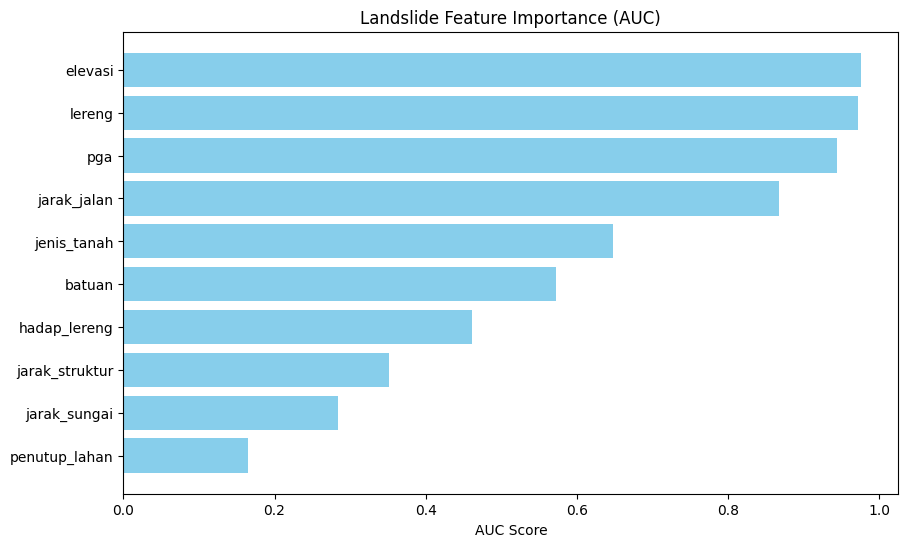

In [13]:
# Sort features by AUC (descending)
ranked_features = auc_df.sort_values('AUC', ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(ranked_features.index, ranked_features['AUC'], color='skyblue')
plt.xlabel('AUC Score')
plt.title('Landslide Feature Importance (AUC)')
plt.gca().invert_yaxis()  # Highest AUC at the top
plt.show()

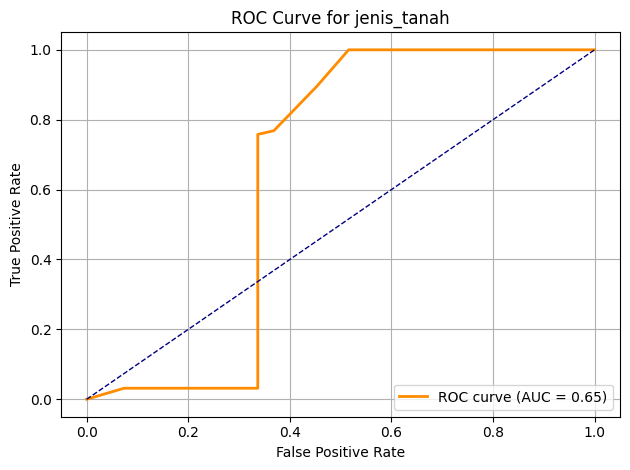

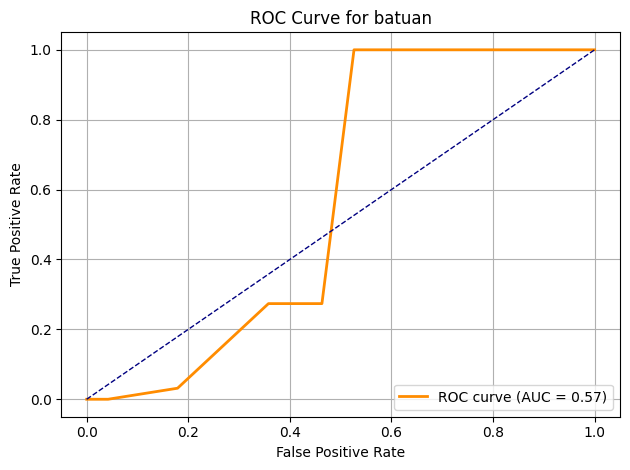

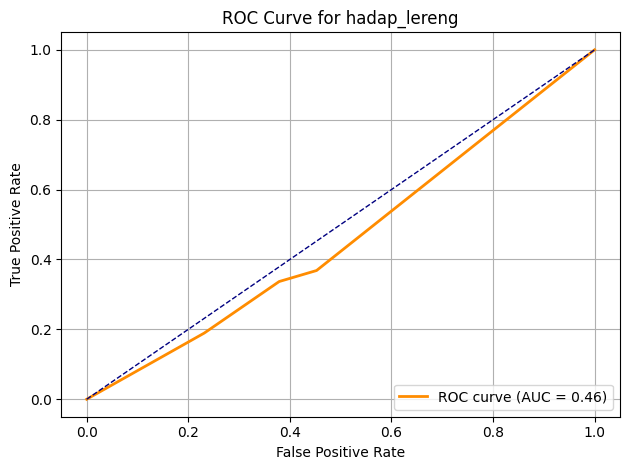

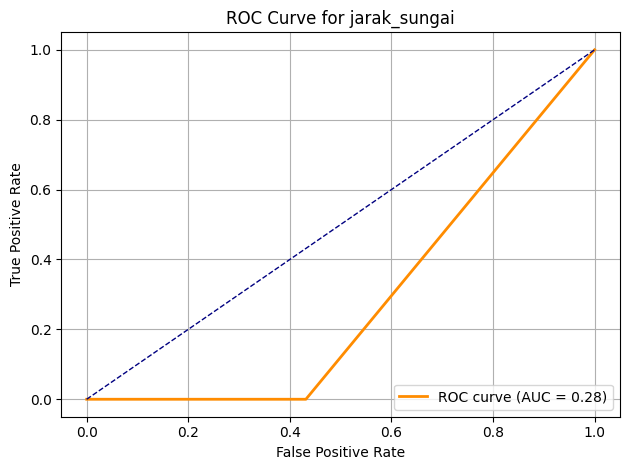

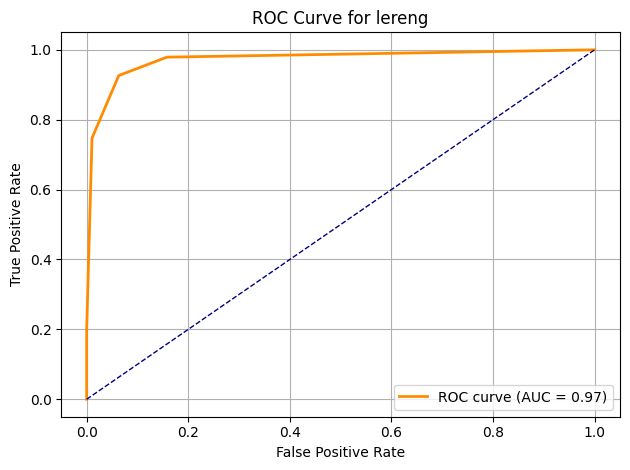

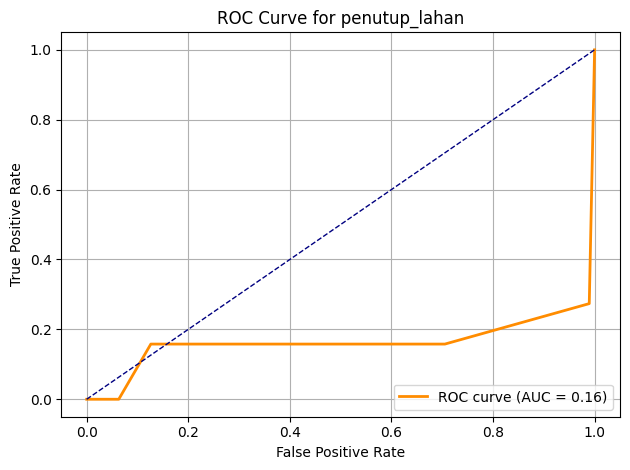

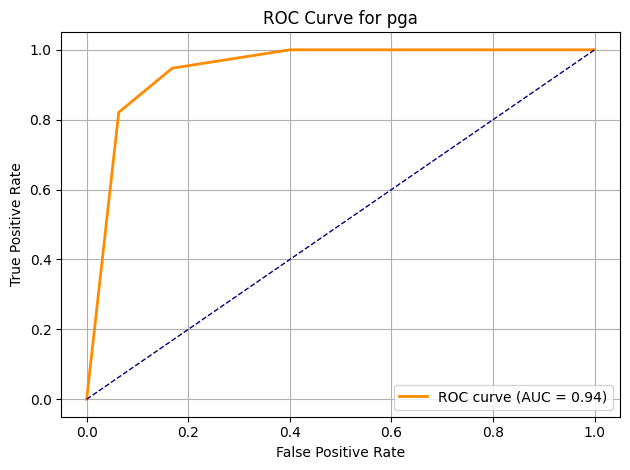

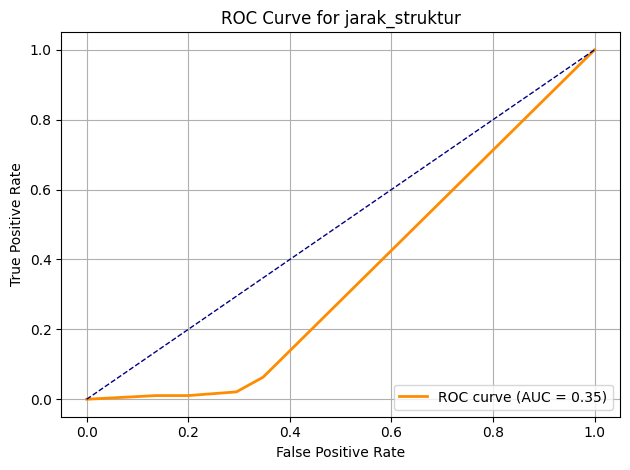

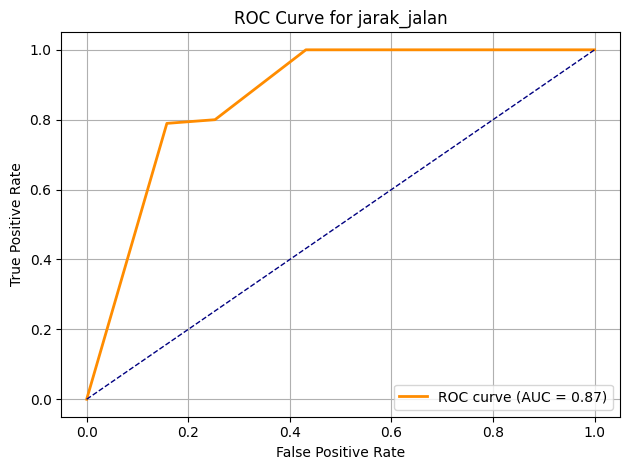

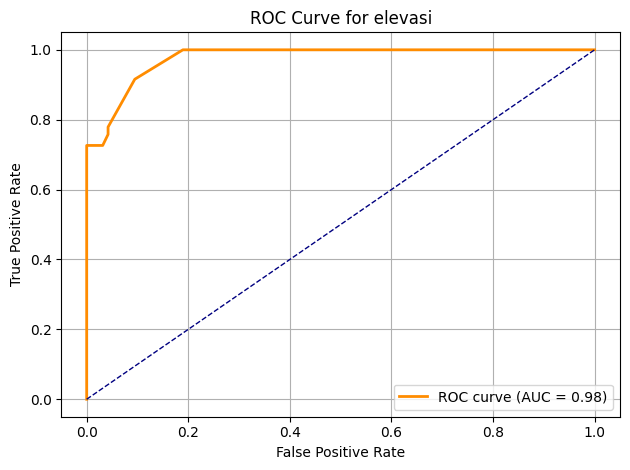

In [14]:
# Plot ROC curve for each feature
for feature in features:
    y_true = y
    y_scores = df[feature]

    # Some features may throw error if only one class or constant values
    try:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = sklearn_auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {feature}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Could not plot ROC for {feature}: {e}")

In [15]:
selected_features = ranked_features[ranked_features['AUC'] >= 0.6].index.tolist()
print("Selected Features:", selected_features)

Selected Features: ['elevasi', 'lereng', 'pga', 'jarak_jalan', 'jenis_tanah']


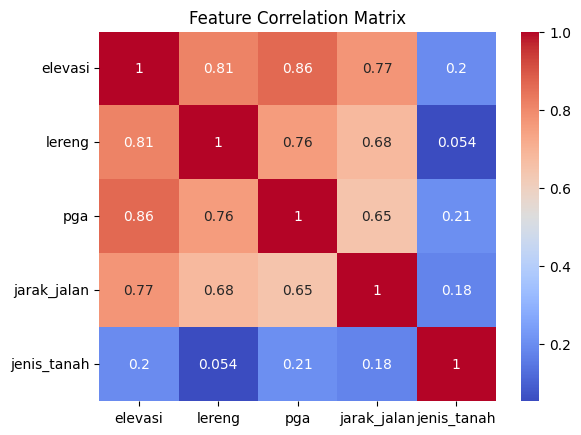

In [18]:
# Check correlation between selected features
correlation_matrix = X[selected_features].corr()

import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], 
    df['longsor'], 
    test_size=0.3, 
    random_state=42,
    stratify=df['longsor']  # Maintain landslide/non-landslide ratio
)

In [22]:
print("X train: ", X_train.shape, "X test: ", X_test.shape)

X train:  (133, 10) X test:  (57, 10)


In [23]:
# Calculate weights for one feature
def calculate_weights(feature, target='longsor'):
    crosstab = pd.crosstab(df[feature], df[target])
    
    # Add small value (Laplace smoothing) to avoid division by zero
    crosstab = crosstab + 0.5
    
    # Probabilities
    p_feature_landslide = crosstab[1] / crosstab[1].sum()
    p_feature_non_landslide = crosstab[0] / crosstab[0].sum()
    
    # Weights
    W_plus = np.log(p_feature_landslide / p_feature_non_landslide)
    W_minus = np.log((1 - p_feature_landslide) / (1 - p_feature_non_landslide))
    C = W_plus - W_minus
    
    return pd.DataFrame({'W_plus': W_plus, 'W_minus': W_minus, 'C': C})

# Calculate for all features
weights = {feature: calculate_weights(feature) for feature in selected_features}
weights

{'elevasi':            W_plus   W_minus         C
 elevasi                              
 1.0     -4.844187  1.002845 -5.847032
 2.0     -3.367296  0.151641 -3.518937
 3.0     -0.111226  0.010989 -0.122215
 4.0      0.897942 -0.088455  0.986397
 5.0      1.609438 -0.020305  1.629743
 6.0      0.847298 -0.020514  0.867811
 7.0     -1.098612  0.010101 -1.108713
 8.0     -1.609438  0.020305 -1.629743
 9.0      1.945910 -0.030615  1.976525
 10.0     4.890349 -1.088612  5.978961,
 'lereng':           W_plus   W_minus         C
 lereng                              
 1.0    -3.471966  1.720664 -5.192630
 2.0    -0.546544  0.044452 -0.590995
 3.0     1.157453 -0.139762  1.297215
 4.0     3.555348 -0.757686  4.313034
 5.0     3.663562 -0.218002  3.881564,
 'pga':        W_plus   W_minus         C
 pga                              
 1.0 -3.433987  0.167992 -3.601979
 2.0 -4.442651  0.567378 -5.010029
 3.0 -1.408767  0.204300 -1.613068
 4.0  0.174353 -0.023257  0.197610
 5.0  2.491296 -1.566421  

In [24]:
# Rank features by overall contrast
feature_importance = {feature: weights[feature]['C'].abs().mean() 
                      for feature in selected_features}
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("Feature Importance (C):")
for feature, C in sorted_features:
    print(f"{feature}: {C:.2f}")

Feature Importance (C):
lereng: 3.06
pga: 2.90
jarak_jalan: 2.65
elevasi: 2.37
jenis_tanah: 2.36


In [25]:
# Convert to a multi-indexed DataFrame
woe_df = pd.concat(
    {feature: df for feature, df in weights.items()},
    names=['feature', 'class']
).reset_index()

# Reorder and rename columns
woe_df = woe_df[['feature', 'class', 'W_plus', 'W_minus', 'C']]
woe_df.columns = ['Feature', 'Class', 'W+', 'W-', 'Contrast (C)']

In [17]:
woe_df

,Feature,Class,W+,W-,Contrast (C)
0,elevasi,1.0,-4.844187,1.002845,-5.847032
1,elevasi,2.0,-3.367296,0.151641,-3.518937
2,elevasi,3.0,-0.111226,0.010989,-0.122215
3,elevasi,4.0,0.897942,-0.088455,0.986397
4,elevasi,5.0,1.609438,-0.020305,1.629743
5,elevasi,6.0,0.847298,-0.020514,0.867811
6,elevasi,7.0,-1.098612,0.010101,-1.108713
7,elevasi,8.0,-1.609438,0.020305,-1.629743
8,elevasi,9.0,1.945910,-0.030615,1.976525
9,elevasi,10.0,4.890349,-1.088612,5.978961


In [26]:
# Save to CSV with precision control
woe_df.to_csv('woe_results.csv', index=False, float_format='%.6f')